Here I showed a shortcoming of the method, and how to tackle it manually.

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from util import RuleClassifier, get_complexity, evaluate_counterfactual_fidelity
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering
from tasks.gaussian_quantiles import make_task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [168]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [169]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker,
                                               explanation_type='indiv', space_type='log_odds')
with open('indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 601it [01:08,  8.18it/s]                         

CPU times: user 1min 4s, sys: 829 ms, total: 1min 5s
Wall time: 1min 8s


In [170]:
%%time
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker,
                                                 explanation_type='mclass_diff', space_type='log_odds')
with open('diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 601it [01:03,  7.84it/s]                         

CPU times: user 1min, sys: 637 ms, total: 1min 1s
Wall time: 1min 3s


# Traditional SHAP Explanations

In [6]:
with open('indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [7]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

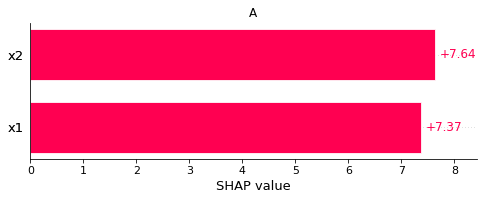

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

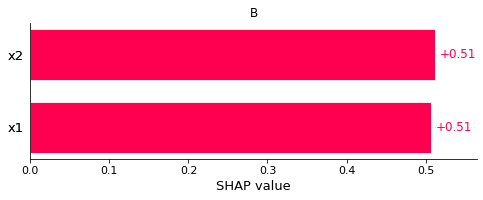

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [10]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 74.5 ms, sys: 4.73 ms, total: 79.2 ms
Wall time: 115 ms


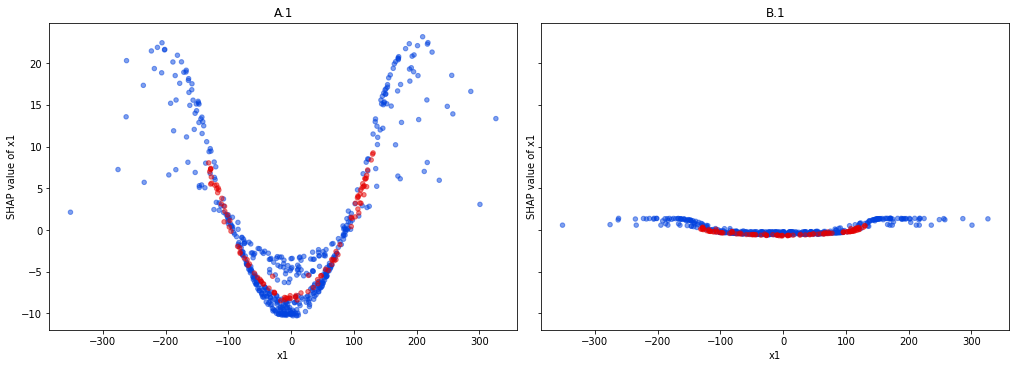

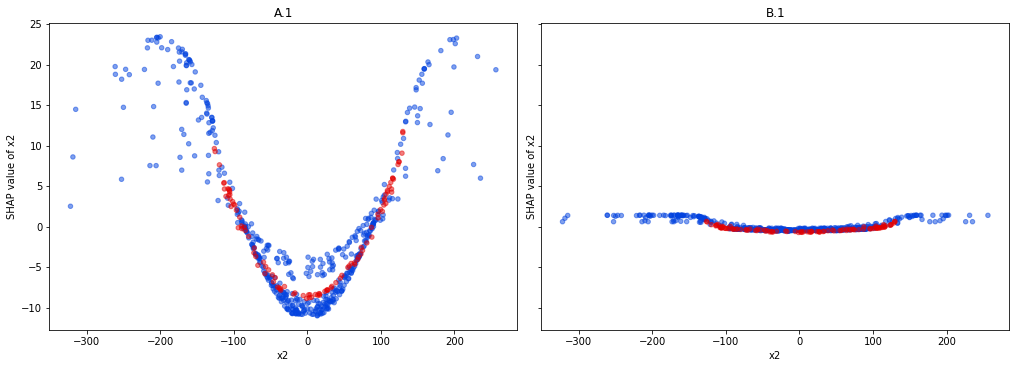

In [11]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [5]:
with open('diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

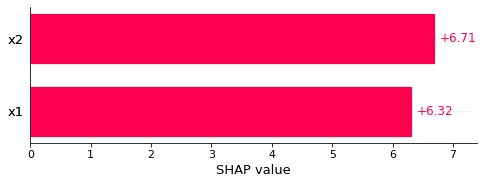

In [6]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

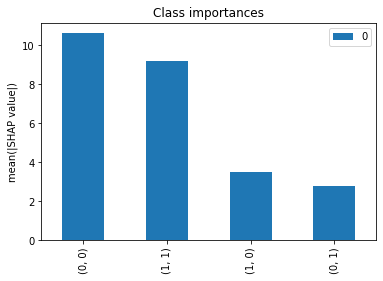

In [7]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

In [8]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## Clustering of Class $(1,0)$ SHAP Values

In [9]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 1min 47s, sys: 1.25 s, total: 1min 49s
Wall time: 2min 9s


((0, 0)    259
 (1, 1)    240
 (1, 0)    101
 dtype: int64,
 7155.744603299222)

In [11]:
with open(f'ground_truth.{node.focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (RL)

In [13]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RL,
 (0, 0)    259
 (1, 0)    101
 (1, 1)     54
 dtype: int64,
 2153.4121830001604)

-131.33844202155564 <= x1 <= 130.61962226695064
[Lower CF: x1 == -143.5 --> {'(1, 1)': 101},
 Upper CF: x1 == 134.3 --> {'(1, 1)': 101}]


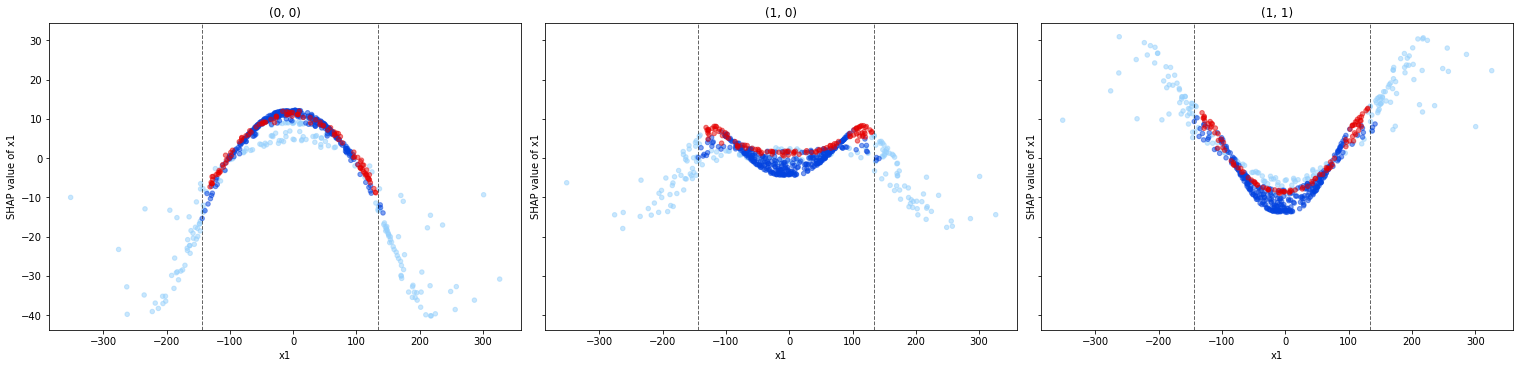

In [15]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

-126.41356491347094 <= x2 <= 129.7495758596666
[Lower CF: x2 == -127.3 --> {'(1, 1)': 101},
 Upper CF: x2 == 132.6 --> {'(1, 1)': 101}]


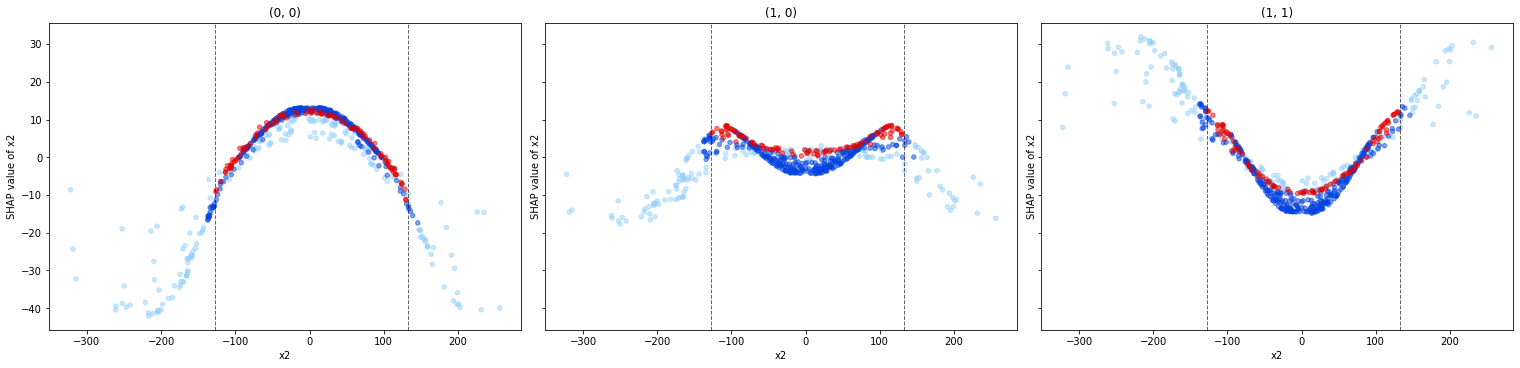

In [16]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

In [17]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

-127.3 < x2 <= 132.5 and -143.5 < x1 <= 134.2
              precision    recall  f1-score   support

       False       1.00      0.08      0.15       313
        True       0.26      1.00      0.41       101

    accuracy                           0.31       414
   macro avg       0.63      0.54      0.28       414
weighted avg       0.82      0.31      0.22       414



,Precision,Recall,F1 Score,Support
False,1.000000,0.083067,0.153392,313
True,0.260309,1.000000,0.413088,101


In [18]:
explanations_global = [(rule, constraint, instance_indices)]

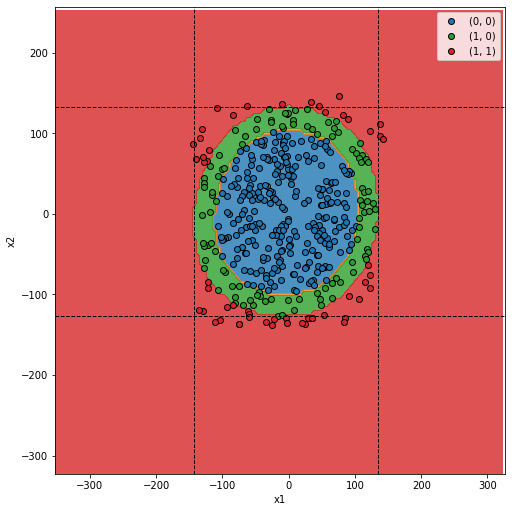

In [19]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 1 (RLL)

In [20]:
node = node.get_left().get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLL,
 (0, 0)    77
 (1, 0)    50
 (1, 1)    34
 dtype: int64,
 1008.5755069618963)

CFs are closer.

-85.21550165878162 <= x1 <= 77.85447754205681
[Lower CF: x1 == -121.1 --> {'(1, 1)': 50},
 Upper CF: x1 == 108.4 --> {'(1, 1)': 50}]


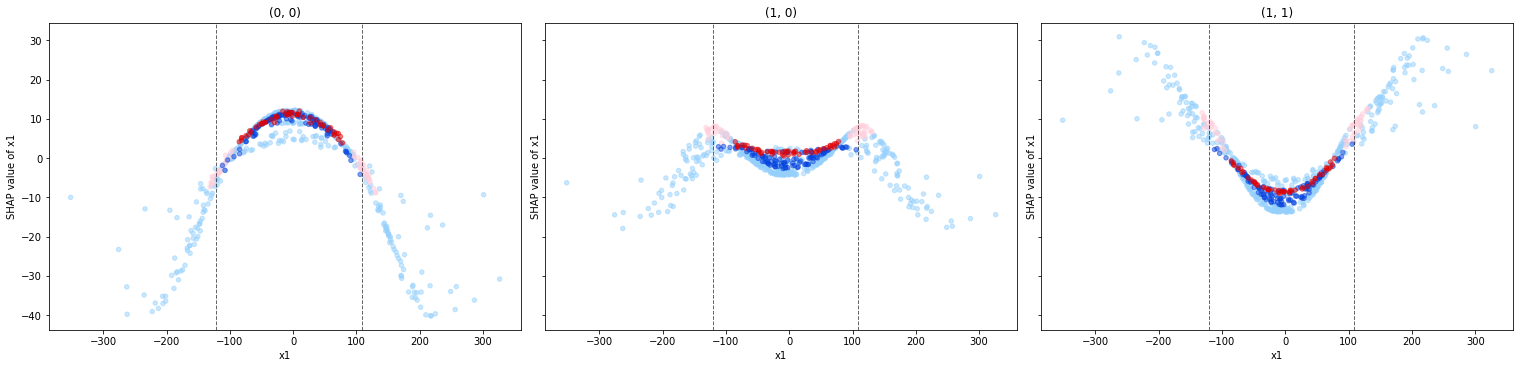

In [22]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

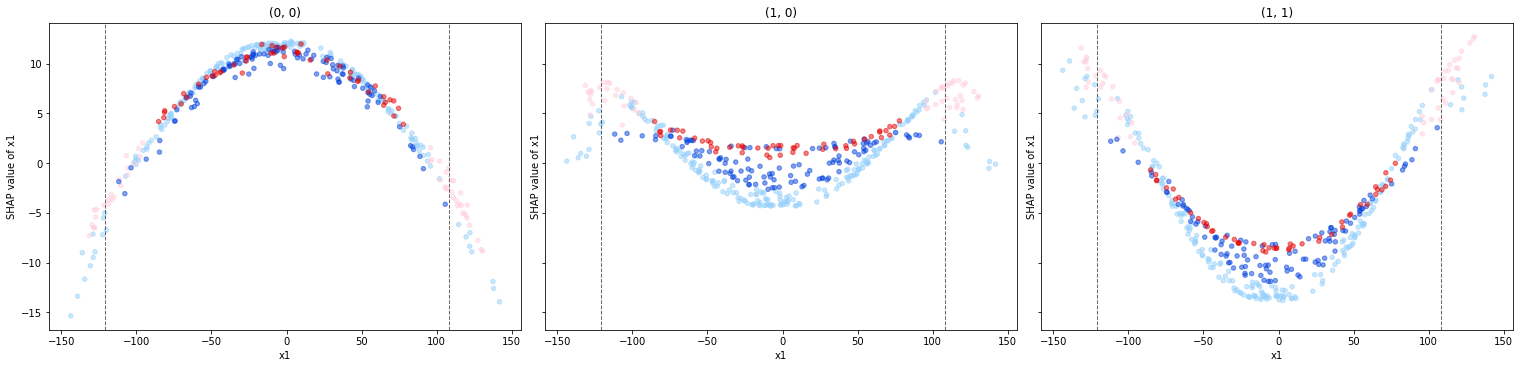

In [23]:
node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

Differences are on the boundaries of the parent. CFs are equal to parent.

-126.41356491347094 <= x2 <= 129.7495758596666
[Lower CF: x2 == -127.3 --> {'(1, 1)': 50},
 Upper CF: x2 == 132.6 --> {'(1, 1)': 50}]


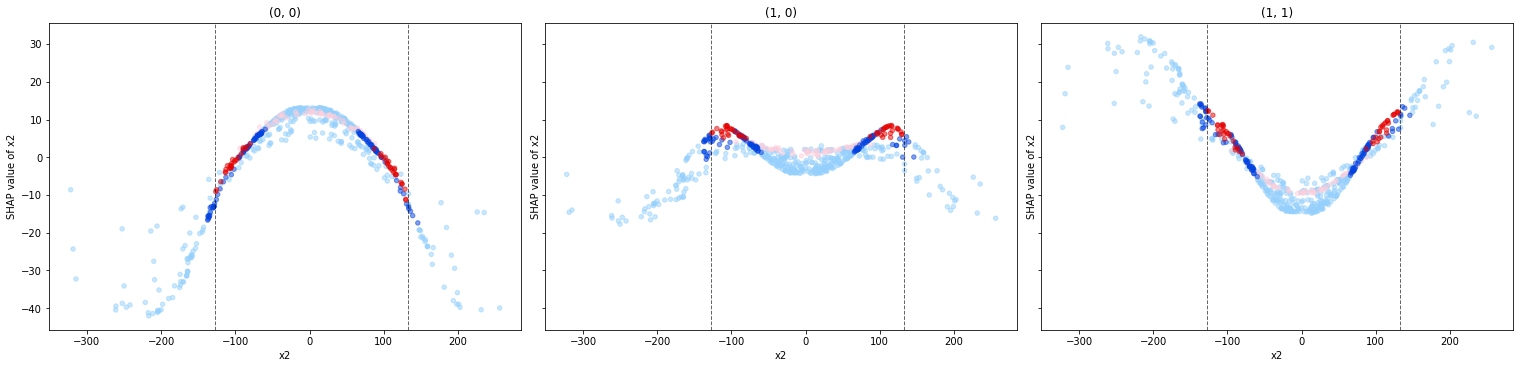

In [24]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

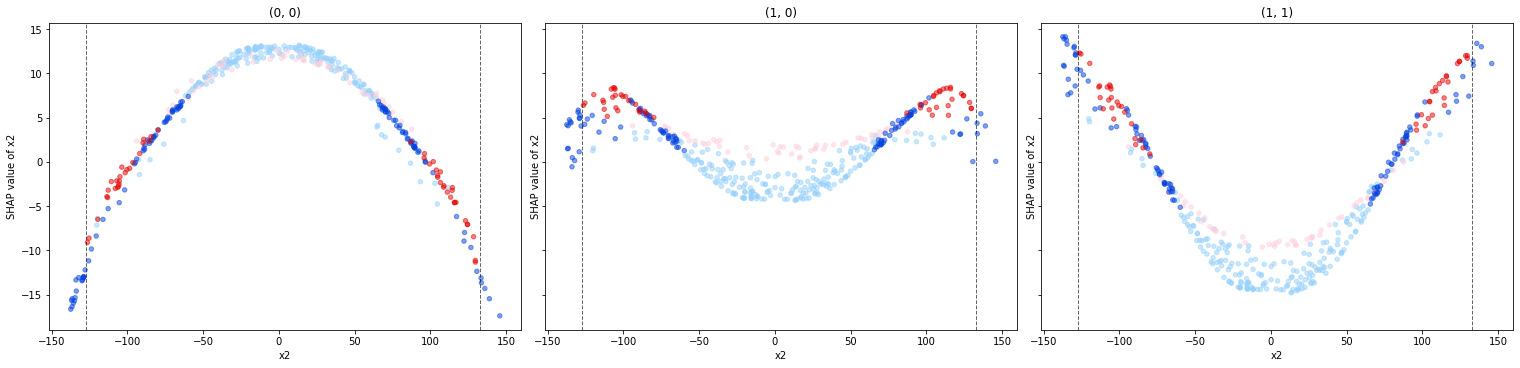

In [25]:
node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

In [26]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

-127.3 < x2 <= 132.5 and -121.1 < x1 <= 108.3
              precision    recall  f1-score   support

       False       1.00      0.20      0.33       111
        True       0.36      1.00      0.53        50

    accuracy                           0.45       161
   macro avg       0.68      0.60      0.43       161
weighted avg       0.80      0.45      0.39       161



,Precision,Recall,F1 Score,Support
False,1.000000,0.198198,0.330827,111
True,0.359712,1.000000,0.529101,50


In [27]:
explanations_l1 = [(rule, constraint, instance_indices)]

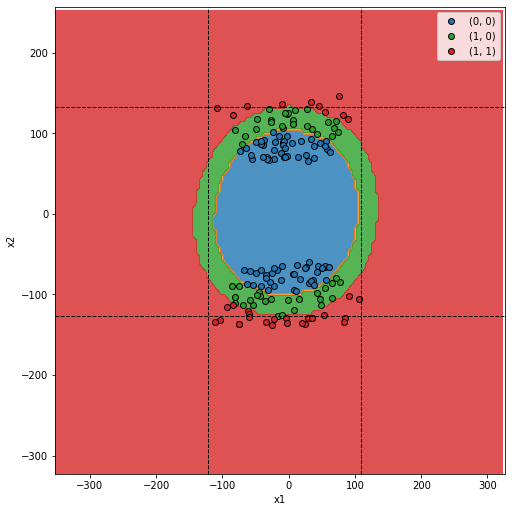

In [28]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 1.1 (RLLLR)

In [29]:
node = node.get_left().get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLLLR,
 (1, 0)    41
 (0, 0)    12
 dtype: int64,
 269.55779843029006)

Distribution is similar to parent, with less feature interaction (vertical spread) in $(1,0)$ and $(1,1)$ dependence plots. CFs are equal to parent.

-85.21550165878162 <= x1 <= 77.85447754205681
[Lower CF: x1 == -121.1 --> {'(1, 1)': 41},
 Upper CF: x1 == 108.4 --> {'(1, 1)': 41}]


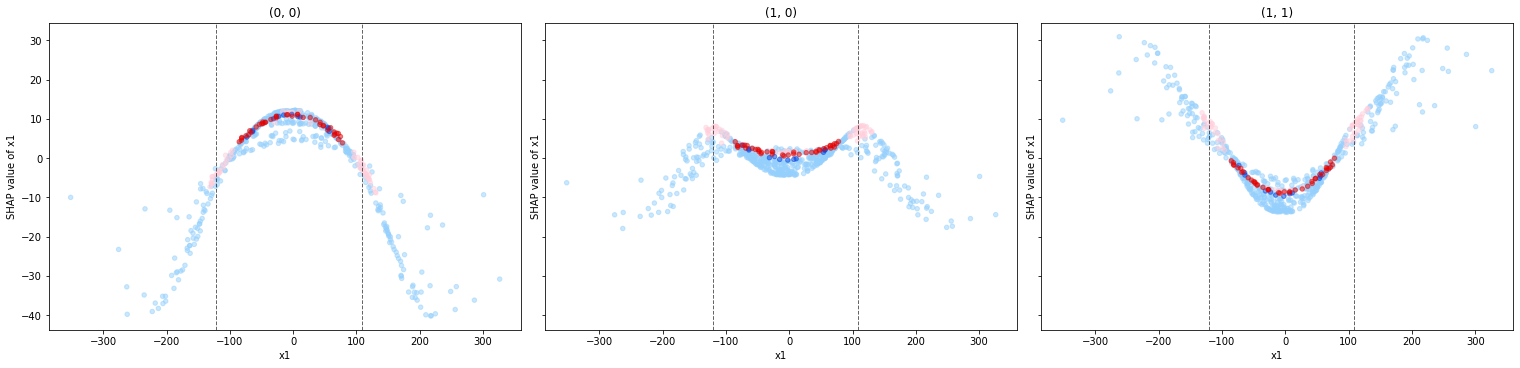

In [31]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

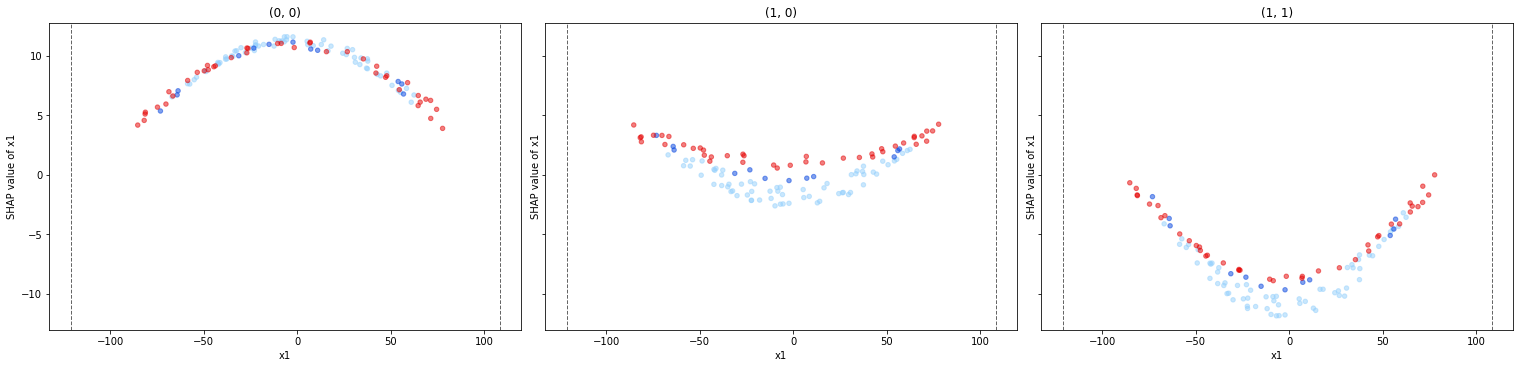

In [32]:
node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

Instances are even further on the rim of the parent cluster. CFs are still the same

-113.56328621239042 <= x2 <= 117.02433684190137
[Lower CF: x2 == -127.3 --> {'(1, 1)': 41},
 Upper CF: x2 == 132.6 --> {'(1, 1)': 41}]


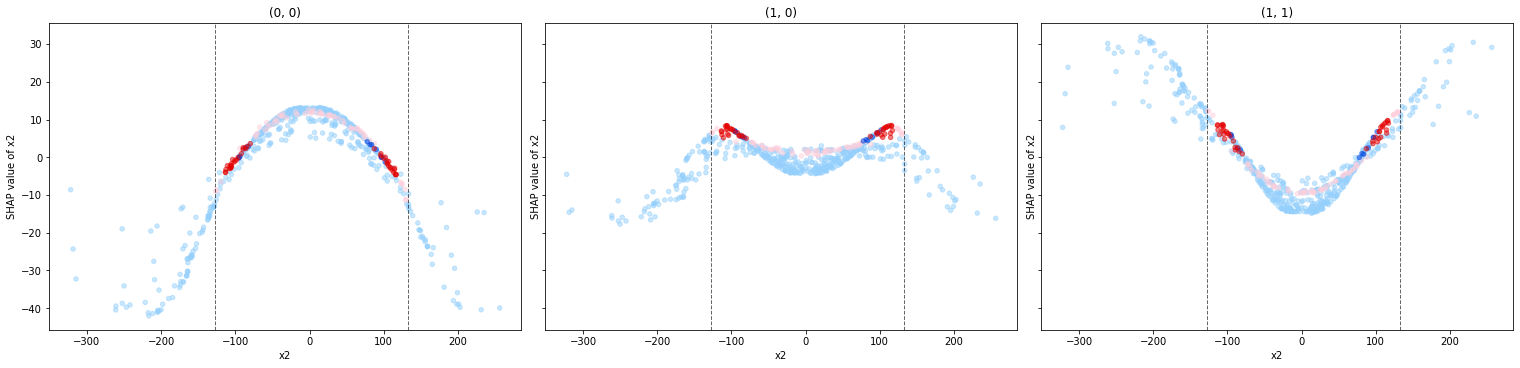

In [33]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

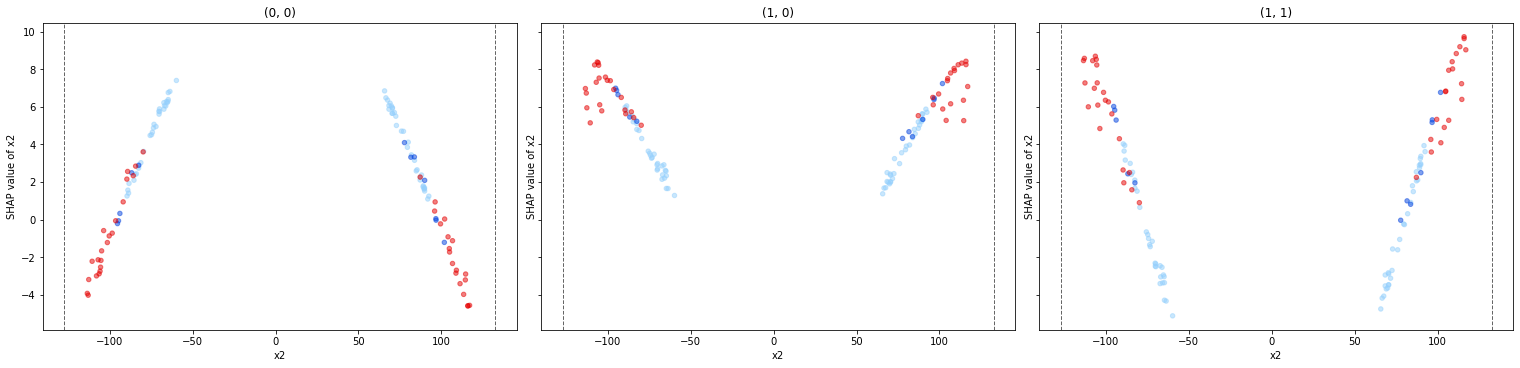

In [34]:
node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

In [35]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

-127.3 < x2 <= 132.5 and -121.1 < x1 <= 108.3
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        12
        True       0.77      1.00      0.87        41

    accuracy                           0.77        53
   macro avg       0.39      0.50      0.44        53
weighted avg       0.60      0.77      0.67        53



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Precision,Recall,F1 Score,Support
False,0.000000,0.0,0.00000,12
True,0.773585,1.0,0.87234,41


In [36]:
explanations_l2 = [(rule, constraint, instance_indices)]

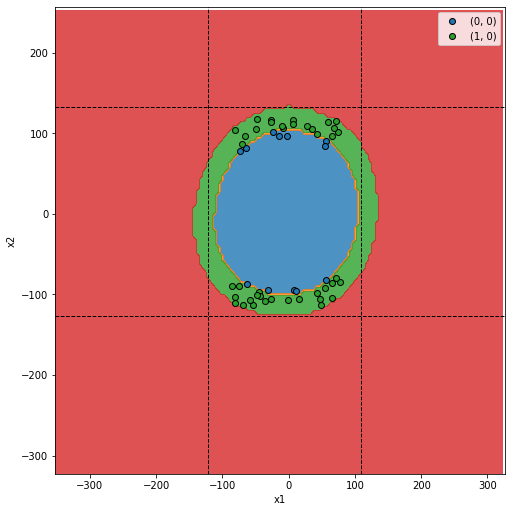

In [37]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

#### Shortcomings

Comparing these dependence plots to the previous, it's clear that the explanation doesn't get much better with deeper levels. I will go down the hierarchy more just to demonstrate a weakness of this method.

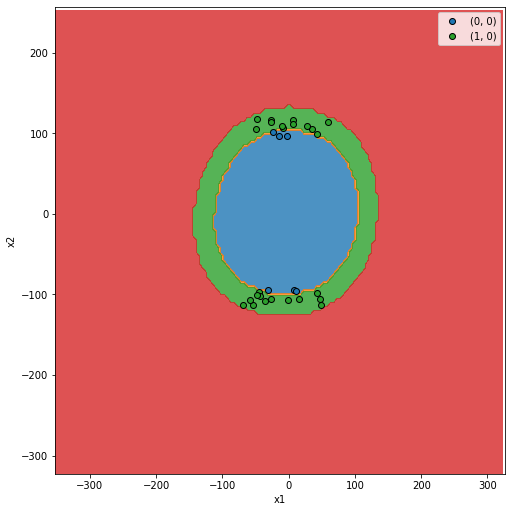

In [38]:
comparer.plot_decision_boundaries(node.get('L').data, xlim=xlim, ylim=ylim, mesh_step_size=5)

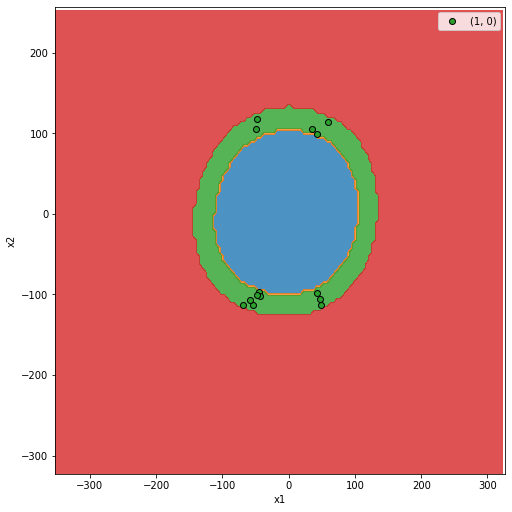

In [39]:
comparer.plot_decision_boundaries(node.get('LL').data, xlim=xlim, ylim=ylim, mesh_step_size=5)

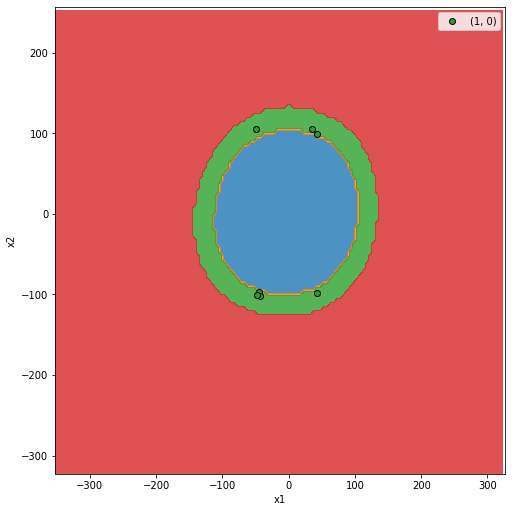

In [40]:
comparer.plot_decision_boundaries(node.get('LLL').data, xlim=xlim, ylim=ylim, mesh_step_size=5)

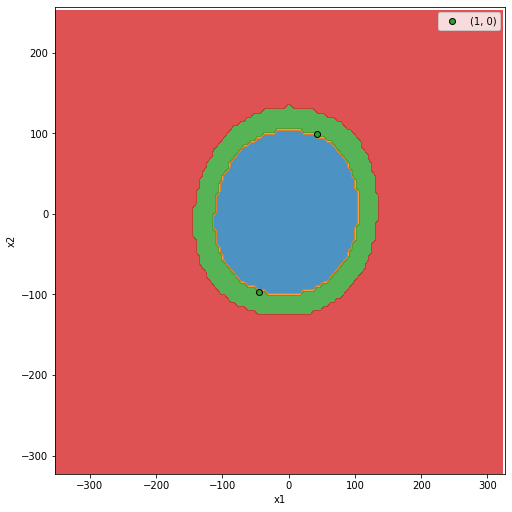

In [41]:
comparer.plot_decision_boundaries(node.get('LLLL').data, xlim=xlim, ylim=ylim, mesh_step_size=5)

We can see, that even at this level, instances from the upper part of the ring and the lower part are not split. This might be the main drawback of this method. The reason is, that the clustering algorithm is based on the SHAP Values only. It does not enable splitting across original feature values. So we are getting an incomplete explanation for this type of difference.

#### Manual Fix

But I can also manually create counterfactuals for instances where x2<0 and >=0:

In [42]:
explanations_l3 = []

In [43]:
part = node.filter(node.shap_values[:, 'x2'].data < 0)
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

-85.21550165878162 <= x1 <= 77.85447754205681
[Lower CF: x1 == -121.1 --> {'(1, 1)': 22},
 Upper CF: x1 == 104.5 --> {'(1, 1)': 22}]
-113.56328621239042 <= x2 <= -79.87248410506523
[Lower CF: x2 == -127.2 --> {'(1, 1)': 22},
 Upper CF: x2 == -67.2 --> {'(0, 0)': 22}]


In [44]:
explanations_l3.append(part.rule_from_counterfactuals())

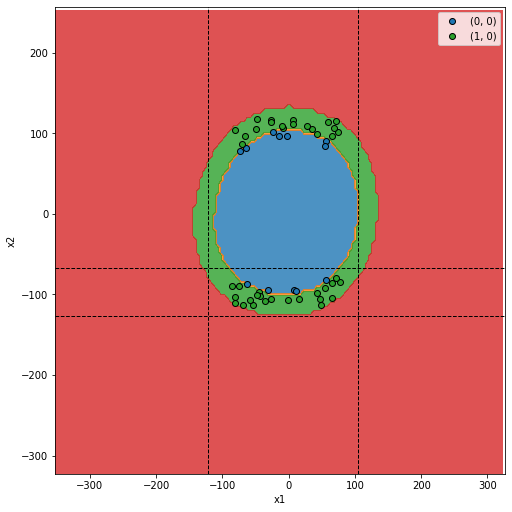

In [45]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [46]:
part = node.filter(node.shap_values[:, 'x2'].data >= 0)
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

-81.76632338846144 <= x1 <= 74.6479354034524
[Lower CF: x1 == -105.5 --> {'(1, 1)': 19},
 Upper CF: x1 == 108.4 --> {'(1, 1)': 19}]
87.1887706640731 <= x2 <= 117.02433684190137
[Lower CF: x2 == 69.4 --> {'(0, 0)': 19},
 Upper CF: x2 == 132.5 --> {'(1, 1)': 19}]


In [47]:
explanations_l3.append(part.rule_from_counterfactuals())

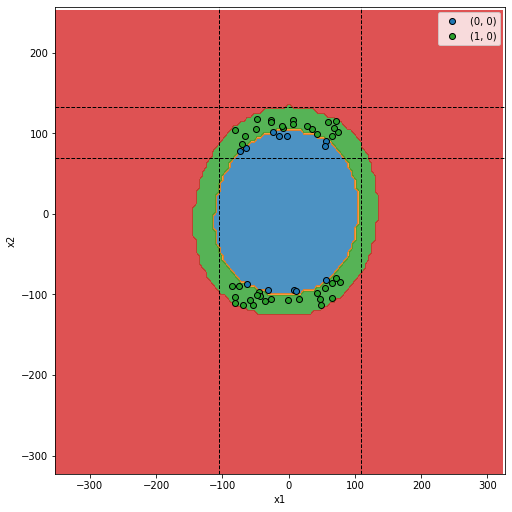

In [48]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 1.2 (RLLRL)

In [49]:
node = node.root.get('RLLR').get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLLRL,
 (1, 1)    19
 (1, 0)     9
 dtype: int64,
 129.13130401387397)

Compared to the parent node, the instances are more in the center, CFs are closer.

-29.45259350592438 <= x1 <= 27.526727519220668
[Lower CF: x1 == -60.6 --> {'(1, 1)': 9},
 Upper CF: x1 == 55.9 --> {'(1, 1)': 9}]


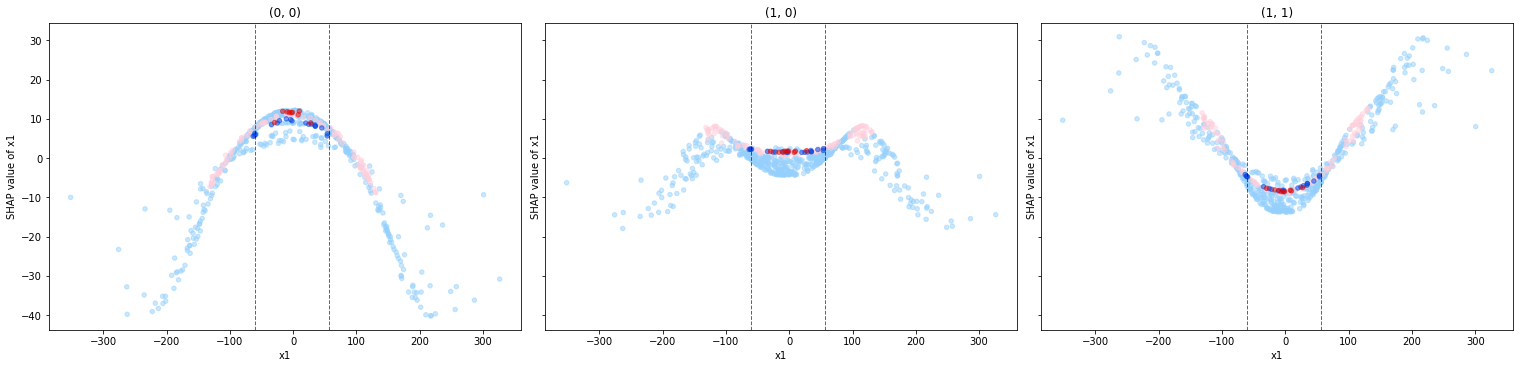

In [51]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

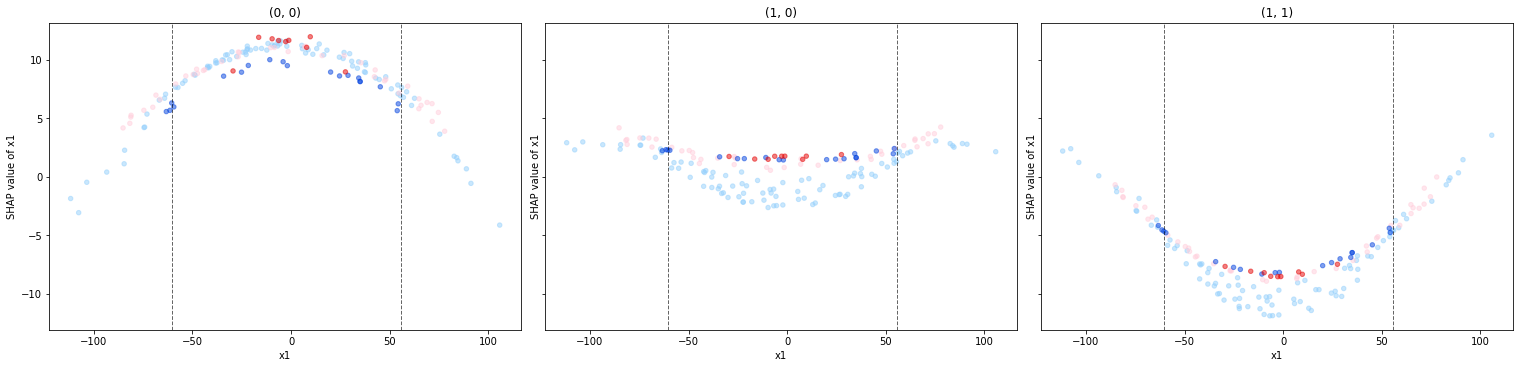

In [52]:
node.get_parent(2).plot_feature_dependence(feature, focus=node, alpha=0.5)

x2 instances are more on the edge compared to the parent. CFs are the same.

-126.41356491347094 <= x2 <= 129.7495758596666
[Lower CF: x2 == -127.3 --> {'(1, 1)': 9},
 Upper CF: x2 == 132.6 --> {'(1, 1)': 9}]


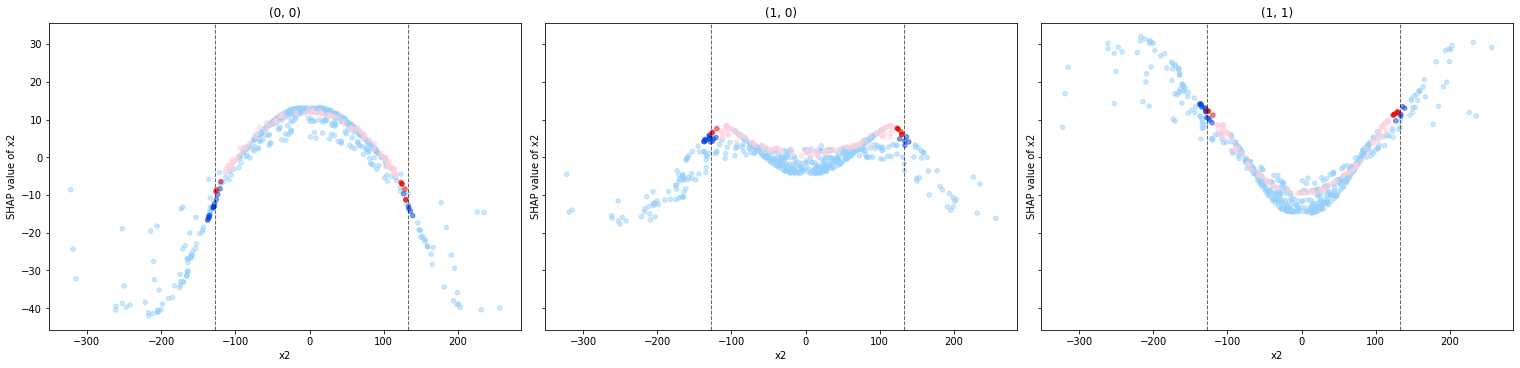

In [53]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

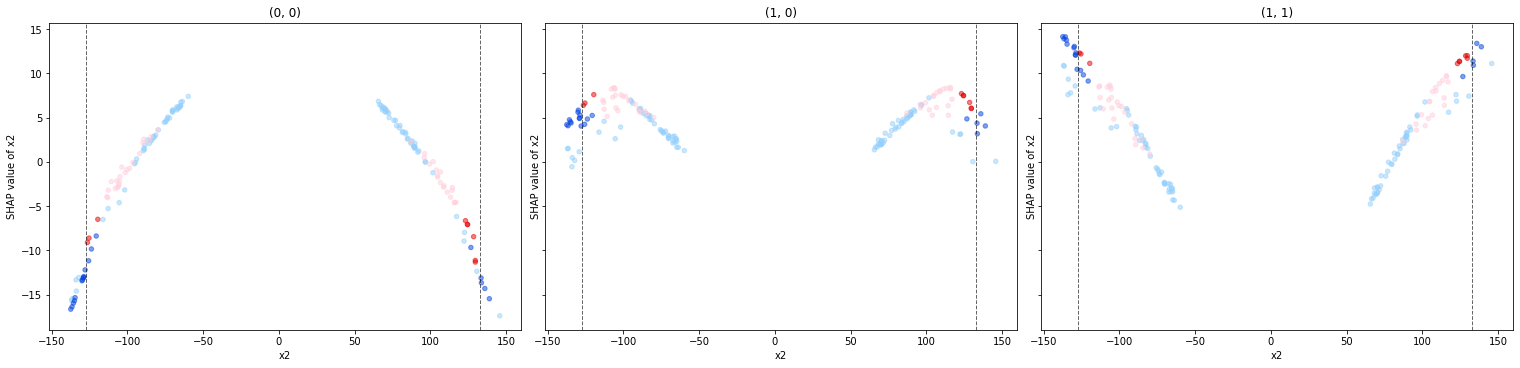

In [54]:
node.get_parent(2).plot_feature_dependence(feature, focus=node, alpha=0.5)

In [55]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

-127.3 < x2 <= 132.5 and -60.6 < x1 <= 55.8
              precision    recall  f1-score   support

       False       1.00      0.84      0.91        19
        True       0.75      1.00      0.86         9

    accuracy                           0.89        28
   macro avg       0.88      0.92      0.89        28
weighted avg       0.92      0.89      0.90        28



,Precision,Recall,F1 Score,Support
False,1.00,0.842105,0.914286,19
True,0.75,1.000000,0.857143,9


In [56]:
explanations_l2.append((rule, constraint, instance_indices))

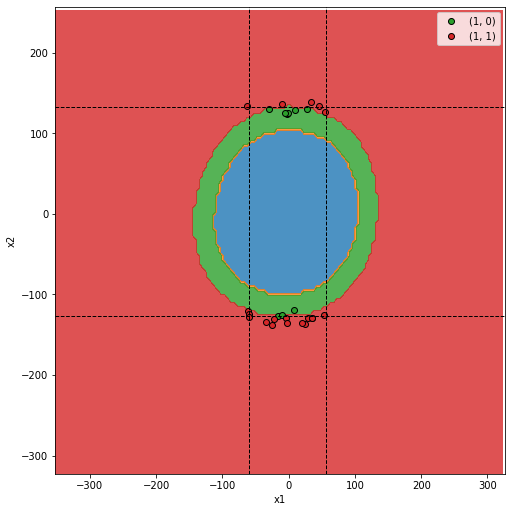

In [57]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

#### Manual Fix

In [58]:
part = node.filter(node.shap_values[:, 'x2'].data < 0)
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

-16.440476964802333 <= x1 <= 7.884816158135244
[Lower CF: x1 == -60.6 --> {'(1, 1)': 3},
 Upper CF: x1 == 44.1 --> {'(1, 1)': 3}]
-126.41356491347094 <= x2 <= -119.54203212105344
[Lower CF: x2 == -127.3 --> {'(1, 1)': 3},
 Upper CF: x2 == -99.1 --> {'(0, 0)': 3}]


In [59]:
explanations_l3.append(part.rule_from_counterfactuals())

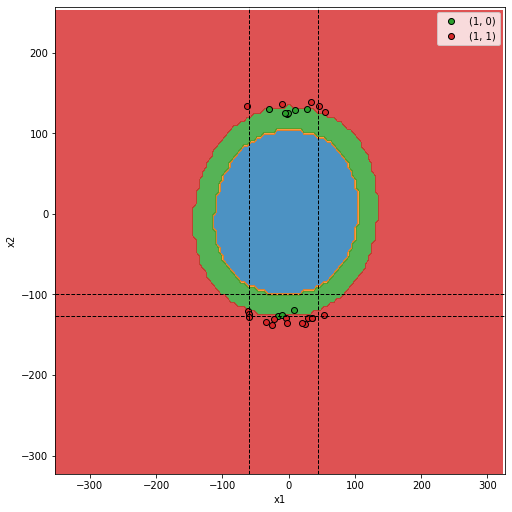

In [60]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [61]:
part = node.filter(node.shap_values[:, 'x2'].data >= 0)
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

-29.45259350592438 <= x1 <= 27.526727519220668
[Lower CF: x1 == -53.1 --> {'(1, 1)': 6},
 Upper CF: x1 == 55.9 --> {'(1, 1)': 6}]
123.24997393547208 <= x2 <= 129.7495758596666
[Lower CF: x2 == 100.4 --> {'(0, 0)': 6},
 Upper CF: x2 == 132.6 --> {'(1, 1)': 6}]


In [62]:
explanations_l3.append(part.rule_from_counterfactuals())

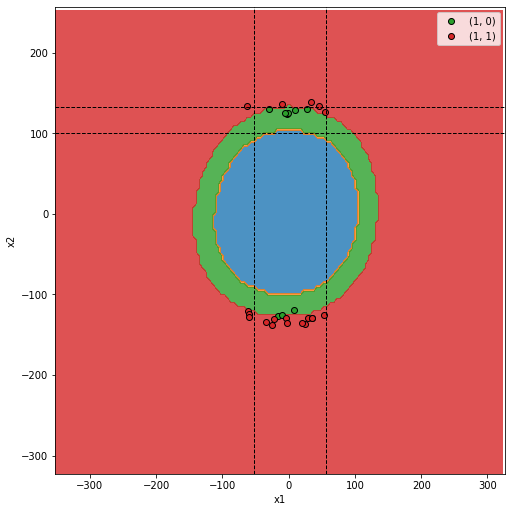

In [63]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2 (RLRR)

In [64]:
node = node.root.get('RLR').get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLRR,
 (0, 0)    62
 (1, 0)    51
 (1, 1)    20
 dtype: int64,
 949.6286373704477)

instances are on the edge of the parent. CFs are equal.

-131.33844202155564 <= x1 <= 130.61962226695064
[Lower CF: x1 == -143.5 --> {'(1, 1)': 51},
 Upper CF: x1 == 134.3 --> {'(1, 1)': 51}]


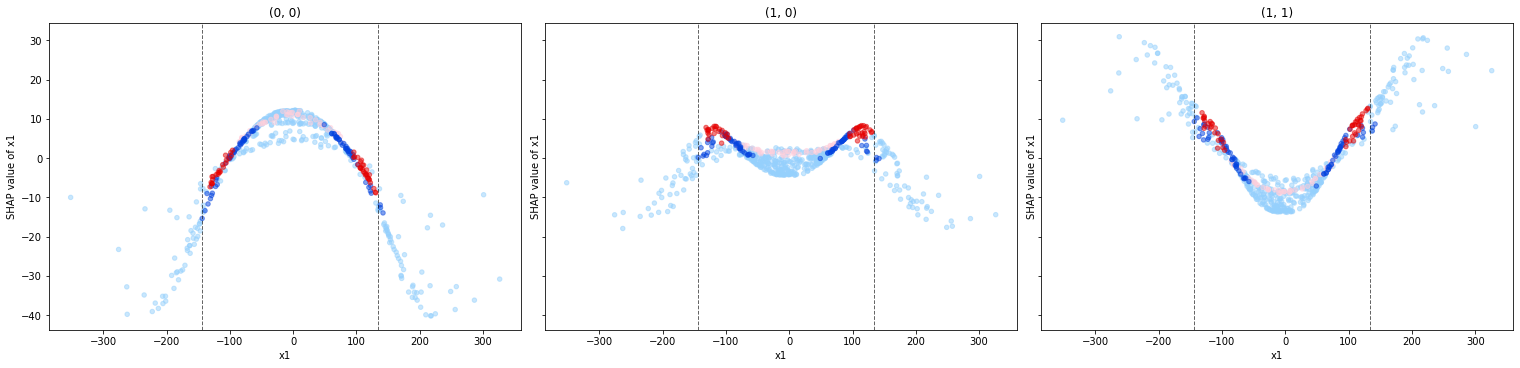

In [66]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

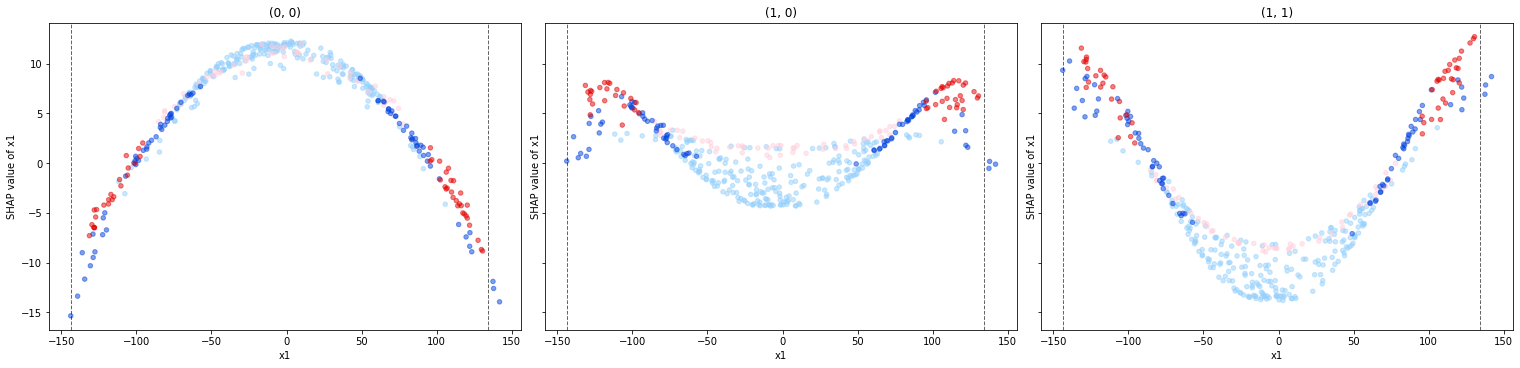

In [67]:
node.get_parent(2).plot_feature_dependence(feature, focus=node, alpha=0.5)

Compared to its parent, the instances here are more in the center, and I see less feature interaction. CFs are closer to the instances.

-93.91635868328355 <= x2 <= 87.70368295639693
[Lower CF: x2 == -103.1 --> {'(1, 1)': 51},
 Upper CF: x2 == 100.4 --> {'(1, 1)': 51}]


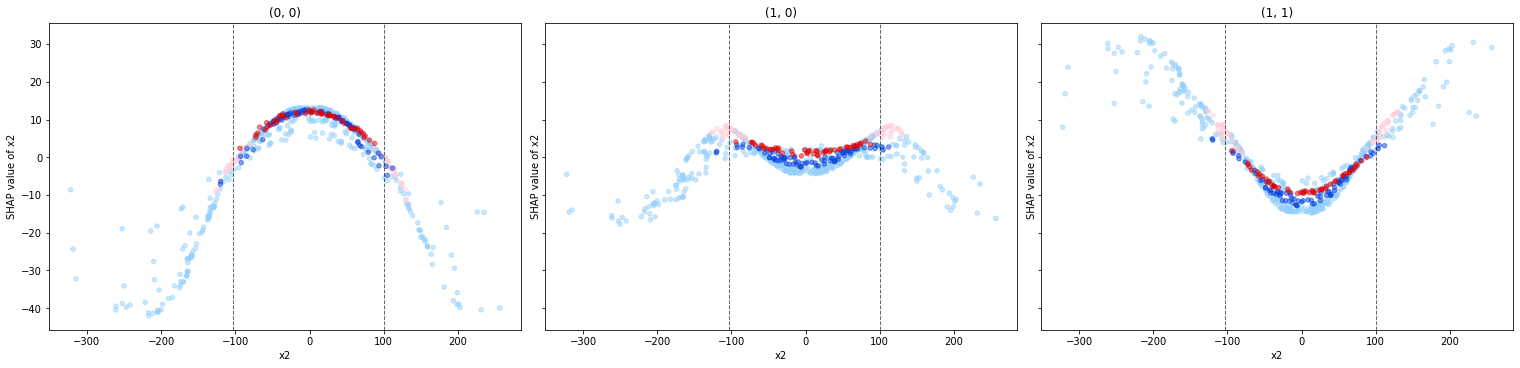

In [68]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

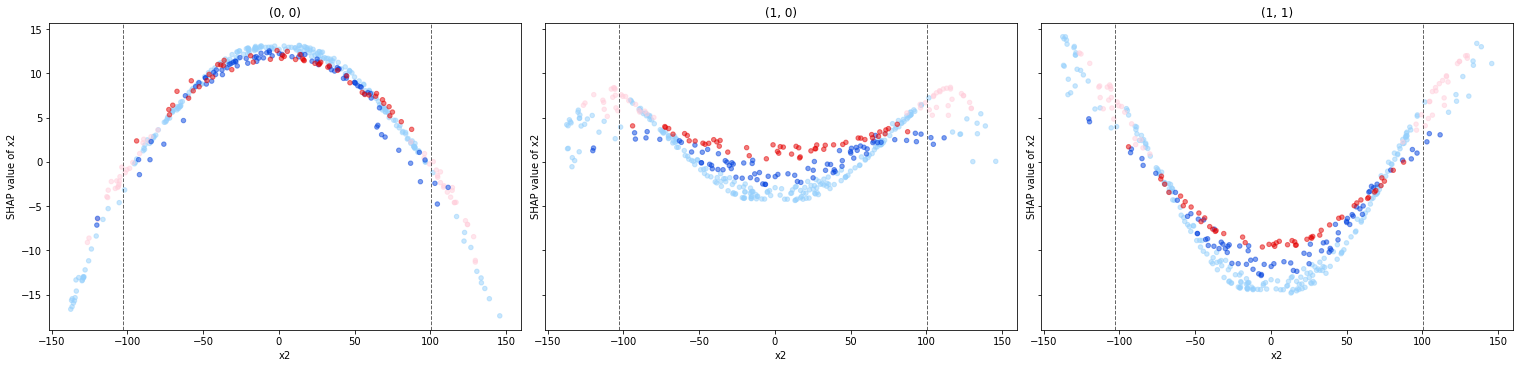

In [69]:
node.get_parent(2).plot_feature_dependence(feature, focus=node, alpha=0.5)

In [70]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

-103.1 < x2 <= 100.3 and -143.5 < x1 <= 134.2
              precision    recall  f1-score   support

       False       1.00      0.10      0.18        82
        True       0.41      1.00      0.58        51

    accuracy                           0.44       133
   macro avg       0.70      0.55      0.38       133
weighted avg       0.77      0.44      0.33       133



,Precision,Recall,F1 Score,Support
False,1.000,0.097561,0.177778,82
True,0.408,1.000000,0.579545,51


In [71]:
explanations_l1.append((rule, constraint, instance_indices))

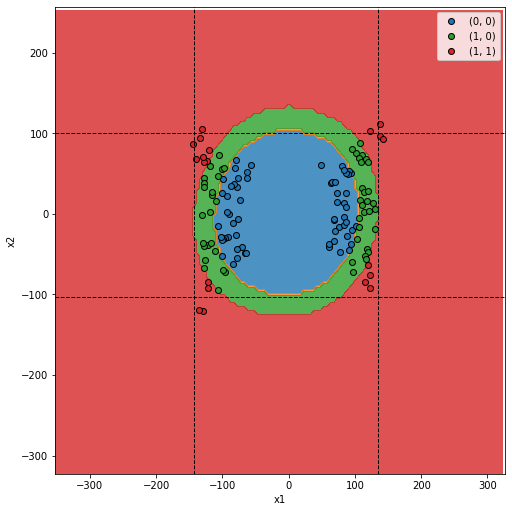

In [72]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.1 (RLRRLL)

In [73]:
node = node.get_left().get_last_child_before_focus_class_split()
node, node.distance, node.class_counts

(RLRRLL,
 165.1293877424797,
 (1, 0)    17
 (0, 0)     7
 dtype: int64)

Instanes are on the inner edge of the parent's instances classified differently, with closer CFs.

-111.22358768774352 <= x1 <= 116.03086492129144
[Lower CF: x1 == -138.7 --> {'(1, 1)': 17},
 Upper CF: x1 == 129.1 --> {'(1, 1)': 17}]


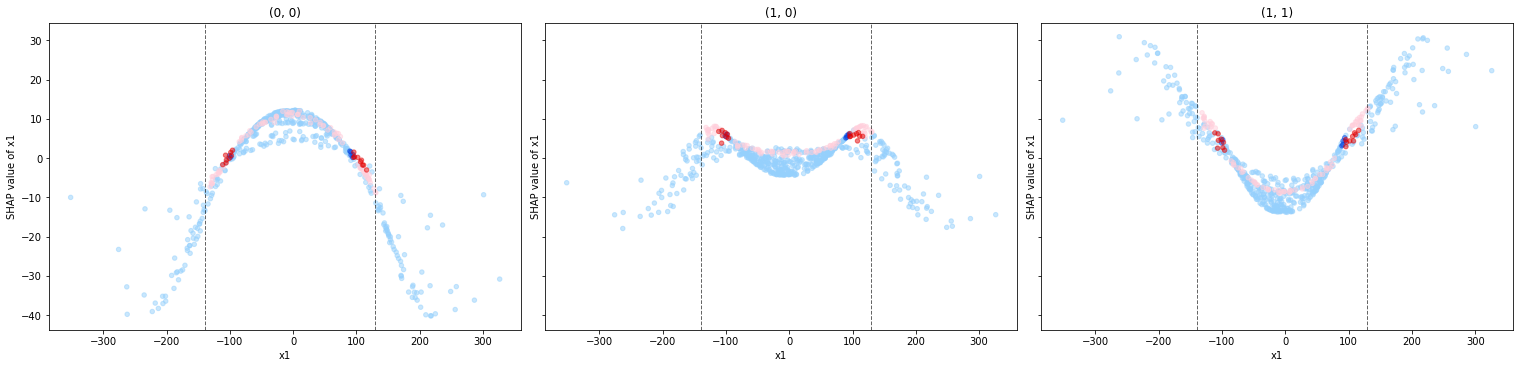

In [75]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

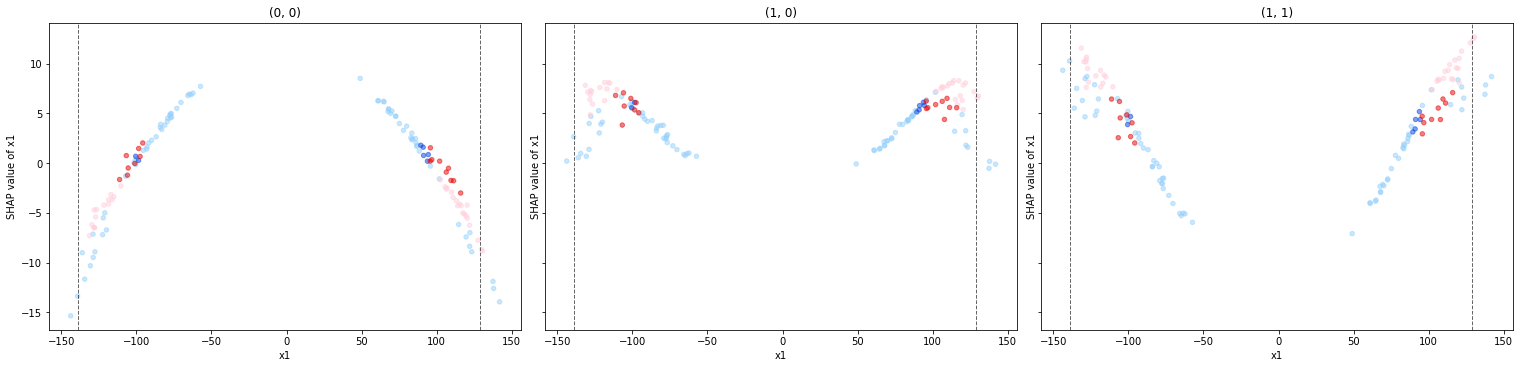

In [76]:
node.get_parent(2).plot_feature_dependence(feature, focus=node, alpha=0.5)

Instances are on the edge of the parent, with equal CFs.

-93.91635868328355 <= x2 <= 87.70368295639693
[Lower CF: x2 == -103.1 --> {'(1, 1)': 17},
 Upper CF: x2 == 100.4 --> {'(1, 1)': 17}]


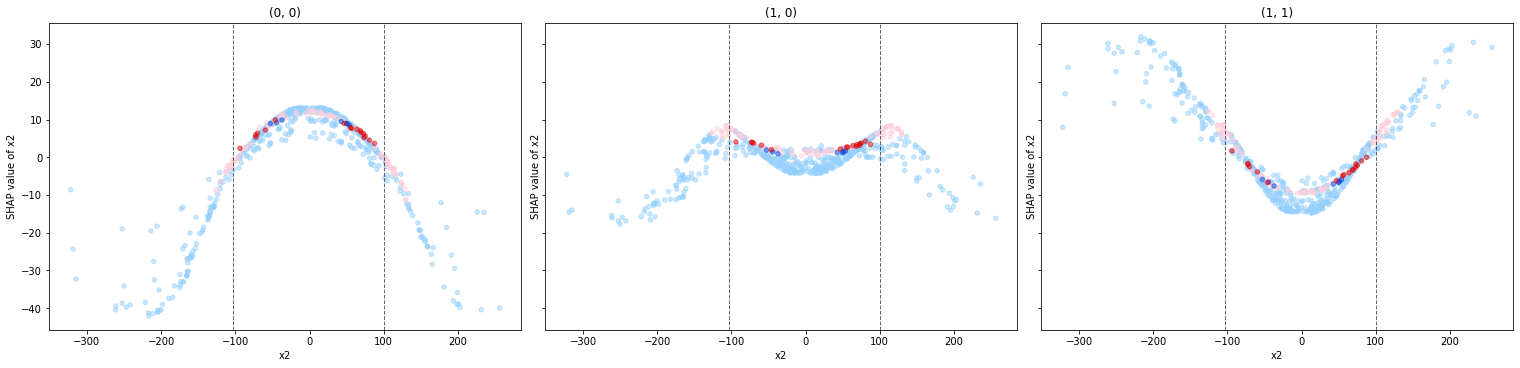

In [77]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

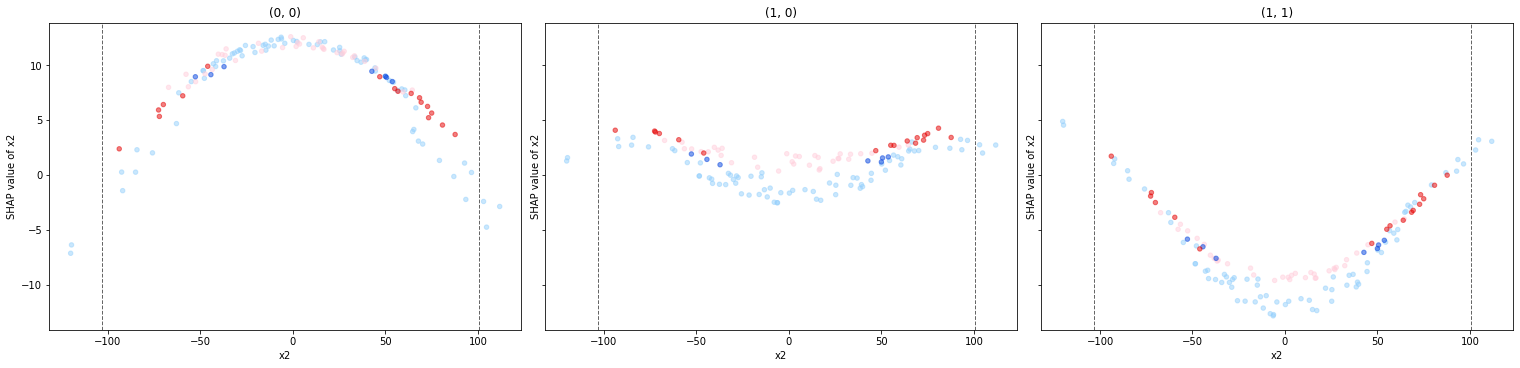

In [78]:
node.get_parent(2).plot_feature_dependence(feature, focus=node, alpha=0.5)

In [79]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

-103.1 < x2 <= 100.3 and -138.7 < x1 <= 129.0
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         7
        True       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Precision,Recall,F1 Score,Support
False,0.000000,0.0,0.000000,7
True,0.708333,1.0,0.829268,17


In [80]:
explanations_l2.append((rule, constraint, instance_indices))

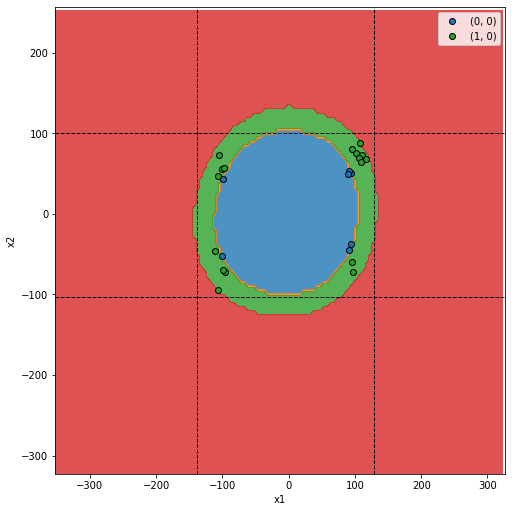

In [81]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

#### Manual Fix

In [82]:
part = node.filter((node.shap_values[:, 'x1'].data < 0) & (node.shap_values[:, 'x2'].data < 0))
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

-111.22358768774352 <= x1 <= -95.7835377788707
[Lower CF: x1 == -138.7 --> {'(1, 1)': 4},
 Upper CF: x1 == -47.0 --> {'(0, 0)': 4}]
-93.91635868328355 <= x2 <= -46.056490937226826
[Lower CF: x2 == -103.1 --> {'(1, 1)': 4},
 Upper CF: x2 == -25.8 --> {'(0, 0)': 4}]


In [83]:
explanations_l3.append(part.rule_from_counterfactuals())

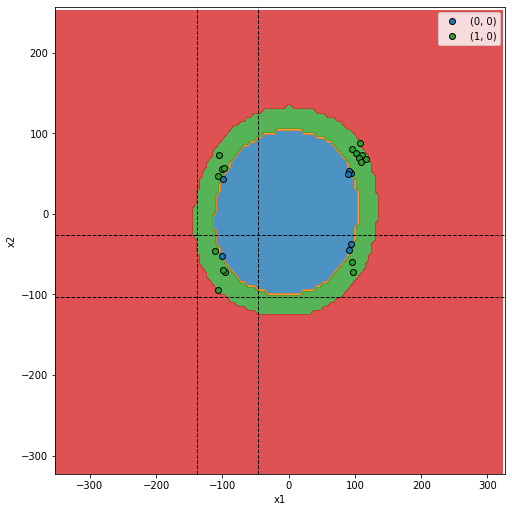

In [84]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [85]:
part = node.filter((node.shap_values[:, 'x1'].data < 0) & (node.shap_values[:, 'x2'].data >= 0))
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

-105.95921759435083 <= x1 <= -97.56182208534048
[Lower CF: x1 == -130.9 --> {'(1, 1)': 4},
 Upper CF: x1 == -78.0 --> {'(0, 0)': 4}]
46.952062697213925 <= x2 <= 73.34409571702292
[Lower CF: x2 == 28.4 --> {'(0, 0)': 4}, Upper CF: x2 == 95.4 --> {'(1, 1)': 4}]


In [86]:
explanations_l3.append(part.rule_from_counterfactuals())

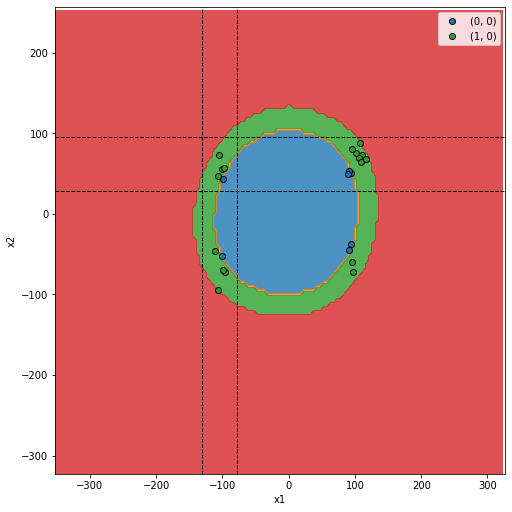

In [87]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [88]:
part = node.filter((node.shap_values[:, 'x1'].data >= 0) & (node.shap_values[:, 'x2'].data < 0))
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

95.72446413633553 <= x1 <= 96.81340376185558
[Lower CF: x1 == 72.8 --> {'(0, 0)': 2},
 Upper CF: x1 == 118.0 --> {'(1, 1)': 2}]
-72.21584403099718 <= x2 <= -59.56530198750573
[Lower CF: x2 == -89.4 --> {'(1, 1)': 2},
 Upper CF: x2 == -37.5 --> {'(0, 0)': 2}]


In [89]:
explanations_l3.append(part.rule_from_counterfactuals())

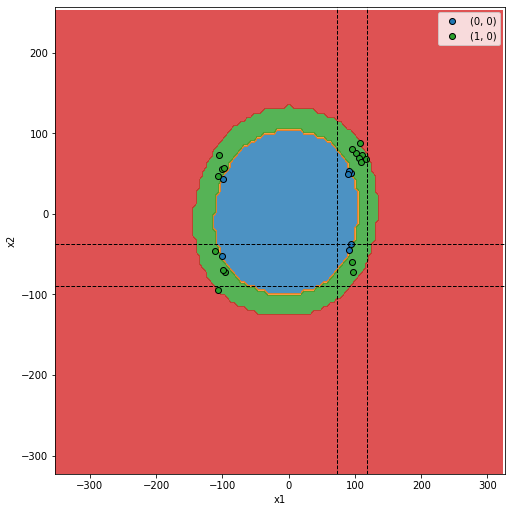

In [90]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [91]:
part = node.filter((node.shap_values[:, 'x1'].data >= 0) & (node.shap_values[:, 'x2'].data >= 0))
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

95.85436324502584 <= x1 <= 116.03086492129144
[Lower CF: x1 == 62.7 --> {'(0, 0)': 7},
 Upper CF: x1 == 122.8 --> {'(1, 1)': 7}]
63.938435073887156 <= x2 <= 87.70368295639693
[Lower CF: x2 == -89.3 --> {'(1, 1)': 7},
 Upper CF: x2 == 100.3 --> {'(1, 1)': 7}]


In [92]:
explanations_l3.append(part.rule_from_counterfactuals())

This last one has low fidelity, because the counterfactual is quite far off.

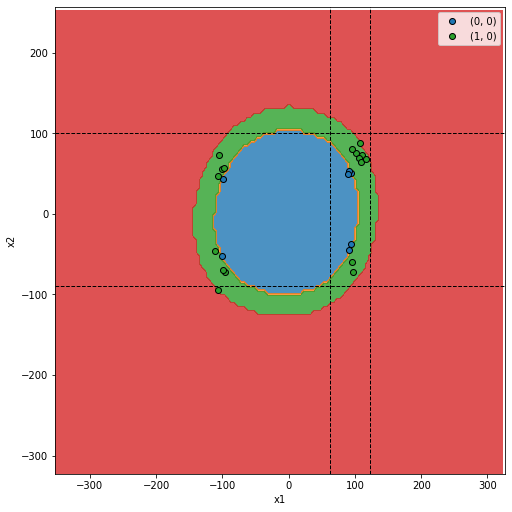

In [93]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.2 (RLRRR)

In [94]:
node = node.root.get('RLRRR').get_last_child_before_focus_class_split()
node, node.distance, node.class_counts

(RLRRRL,
 100.10328889988827,
 (1, 0)    34
 (0, 0)     2
 dtype: int64)

Instanes are on the outer edge of the parent's instances classified differently, with equal CFs.

-131.33844202155564 <= x1 <= 130.61962226695064
[Lower CF: x1 == -143.5 --> {'(1, 1)': 34},
 Upper CF: x1 == 134.3 --> {'(1, 1)': 34}]


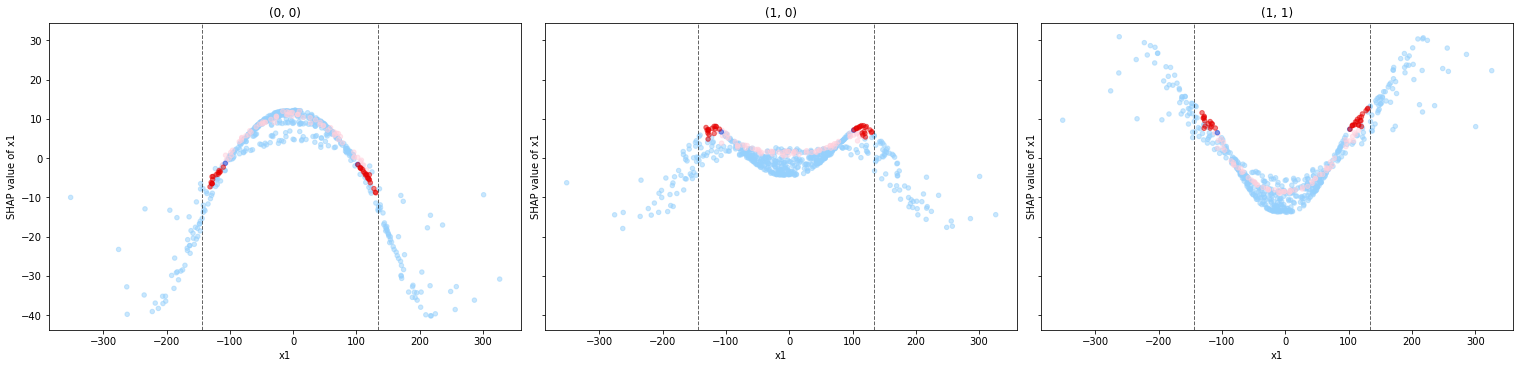

In [96]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

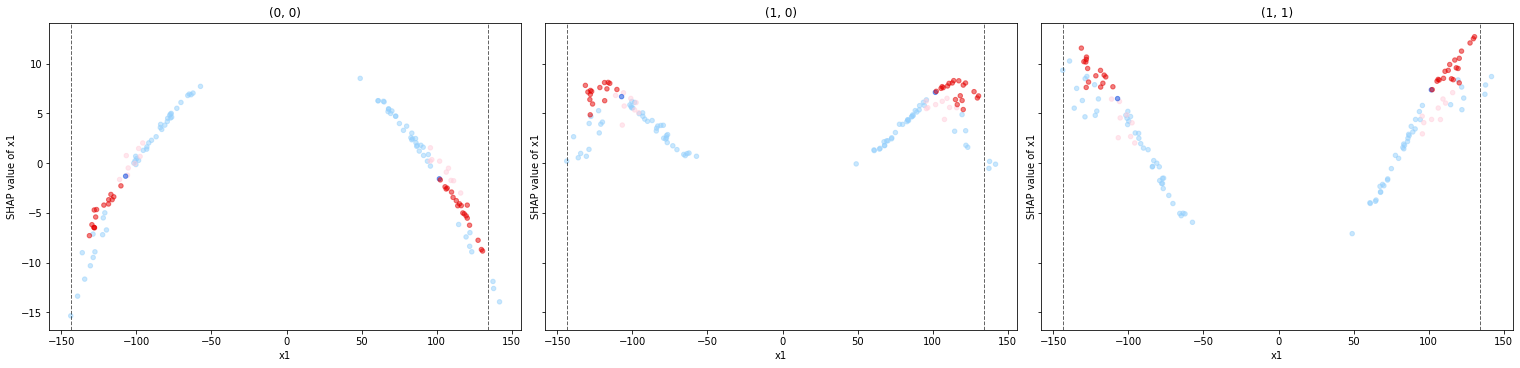

In [97]:
node.get_parent(2).plot_feature_dependence(feature, focus=node, alpha=0.5)

Instances are in the center of the parent's instances classified differently, with closer CFs.

-67.24326704728615 <= x2 <= 64.52053070269106
[Lower CF: x2 == -91.6 --> {'(1, 1)': 34},
 Upper CF: x2 == 94.0 --> {'(1, 1)': 34}]


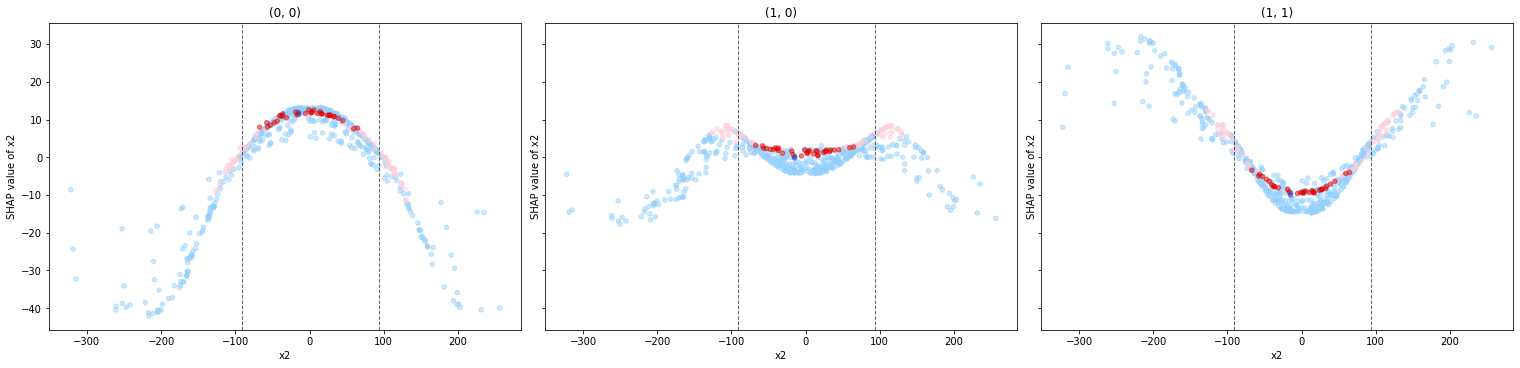

In [98]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

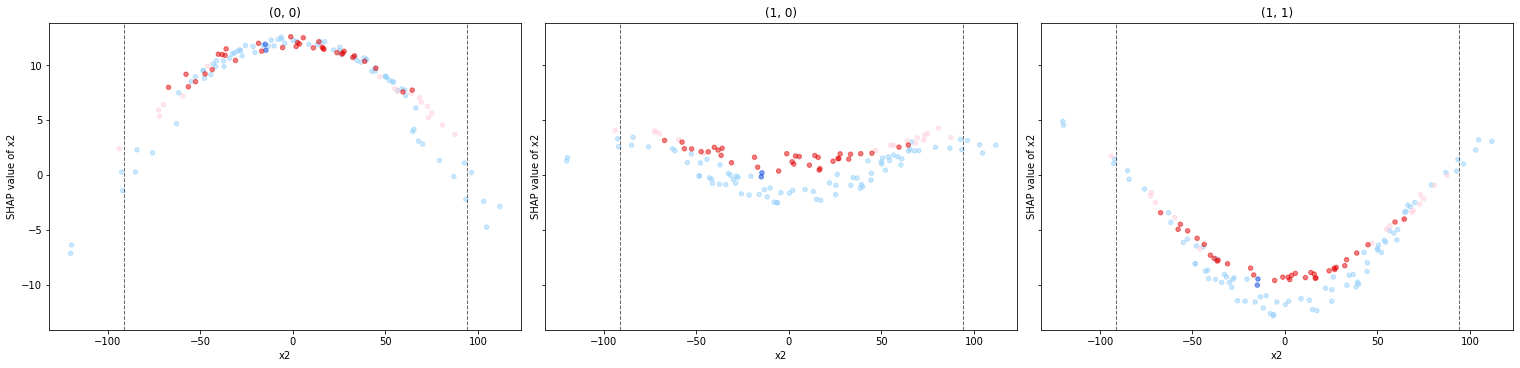

In [99]:
node.get_parent(2).plot_feature_dependence(feature, focus=node, alpha=0.5)

In [100]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

-143.5 < x1 <= 134.2 and -91.6 < x2 <= 93.9
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         2
        True       0.94      1.00      0.97        34

    accuracy                           0.94        36
   macro avg       0.47      0.50      0.49        36
weighted avg       0.89      0.94      0.92        36



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Precision,Recall,F1 Score,Support
False,0.000000,0.0,0.000000,2
True,0.944444,1.0,0.971429,34


In [101]:
explanations_l2.append((rule, constraint, instance_indices))

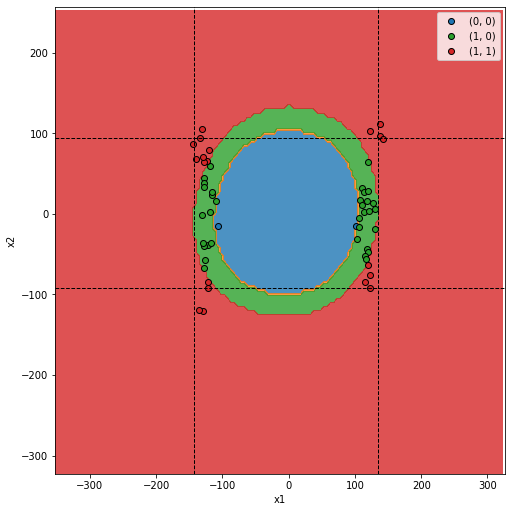

In [102]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

#### Manual Fix

In [103]:
part = node.filter(node.shap_values[:, 'x1'].data < 0)
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

-131.33844202155564 <= x1 <= -110.32973560193824
[Lower CF: x1 == -143.2 --> {'(1, 1)': 15},
 Upper CF: x1 == -89.8 --> {'(0, 0)': 15}]
-67.24326704728615 <= x2 <= 59.49762633795189
[Lower CF: x2 == -91.6 --> {'(1, 1)': 15},
 Upper CF: x2 == 81.4 --> {'(1, 1)': 15}]


In [104]:
explanations_l3.append(part.rule_from_counterfactuals())

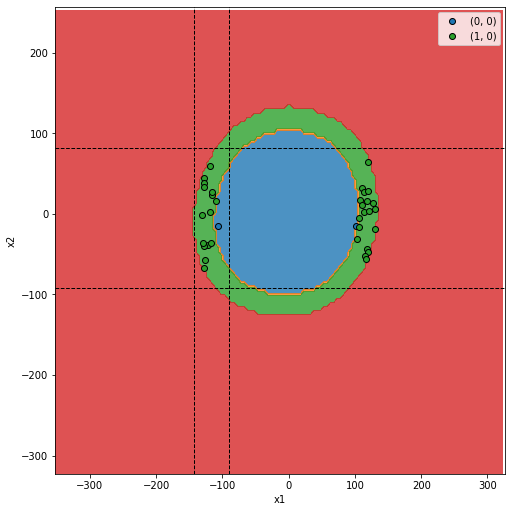

In [105]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [106]:
part = node.filter(node.shap_values[:, 'x1'].data >= 0)
for feature in feature_names:
    part.describe_feature_differences(feature)
    pprint(part.counterfactuals[feature])

102.44016997642824 <= x1 <= 130.61962226695064
[Lower CF: x1 == 86.5 --> {'(0, 0)': 19},
 Upper CF: x1 == 134.3 --> {'(1, 1)': 19}]
-56.536958524810366 <= x2 <= 64.52053070269106
[Lower CF: x2 == -82.3 --> {'(1, 1)': 19},
 Upper CF: x2 == 94.0 --> {'(1, 1)': 19}]


In [107]:
explanations_l3.append(part.rule_from_counterfactuals())

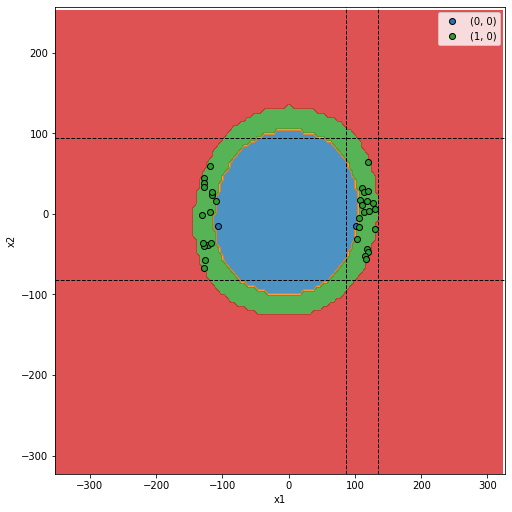

In [108]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, mesh_step_size=5)
for cf in part.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in part.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Evaluation

#### Global

In [109]:
level = 0
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [110]:
print_rules(rules)
global_fidelities[(level, node.focus_class)] = node.root.evaluate_rules(*rules)

1. -127.3 < x2 <= 132.5 and -143.5 < x1 <= 134.2
              precision    recall  f1-score   support

       False       1.00      0.41      0.59       499
        True       0.26      1.00      0.41       101

    accuracy                           0.51       600
   macro avg       0.63      0.71      0.50       600
weighted avg       0.87      0.51      0.56       600



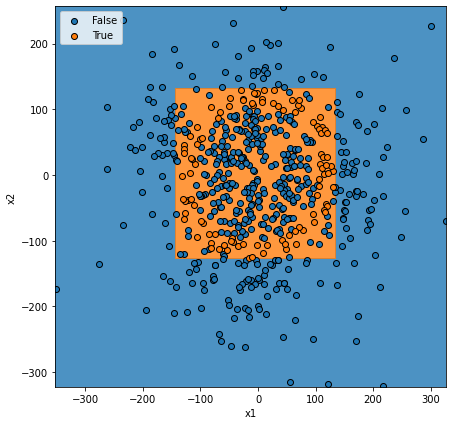

In [111]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

In [112]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,135.194633,0,0
x2,125.338367,0,0


In [113]:
res = get_complexity(constraints)
complexities[(level, node.focus_class)] = res
res

Rules          1
Constraints    4
dtype: int64

#### Level 1

In [114]:
level = 1
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [115]:
print_rules(rules)
global_fidelities[(level, node.focus_class)] = node.root.evaluate_rules(*rules)

1. -127.3 < x2 <= 132.5 and -121.1 < x1 <= 108.3
2. -103.1 < x2 <= 100.3 and -143.5 < x1 <= 134.2
              precision    recall  f1-score   support

       False       1.00      0.42      0.59       499
        True       0.26      1.00      0.41       101

    accuracy                           0.52       600
   macro avg       0.63      0.71      0.50       600
weighted avg       0.88      0.52      0.56       600



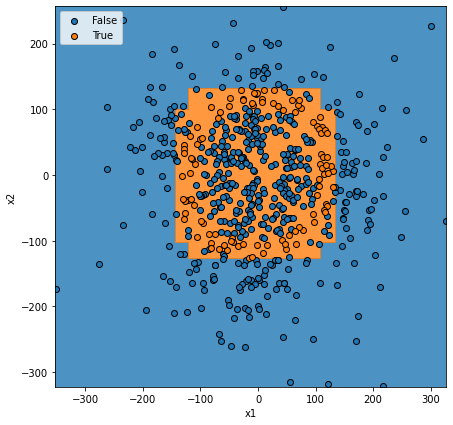

In [116]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

In [117]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,129.009662,0,0
x2,118.463040,0,0


In [118]:
res = get_complexity(constraints)
complexities[(level, node.focus_class)] = res
res

Rules          2
Constraints    8
dtype: int64

#### Level 2

In [119]:
level = 2
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [120]:
print_rules(rules)
global_fidelities[(level, node.focus_class)] = node.root.evaluate_rules(*rules)

1. -127.3 < x2 <= 132.5 and -121.1 < x1 <= 108.3
2. -127.3 < x2 <= 132.5 and -60.6 < x1 <= 55.8
3. -103.1 < x2 <= 100.3 and -138.7 < x1 <= 129.0
4. -143.5 < x1 <= 134.2 and -91.6 < x2 <= 93.9
              precision    recall  f1-score   support

       False       1.00      0.42      0.59       499
        True       0.26      1.00      0.41       101

    accuracy                           0.52       600
   macro avg       0.63      0.71      0.50       600
weighted avg       0.88      0.52      0.56       600



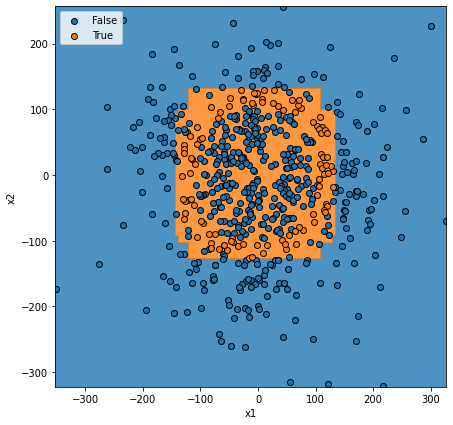

In [121]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

In [122]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,126.356720,0,0
x2,117.630441,0,0


In [123]:
res = get_complexity(constraints)
complexities[(level, node.focus_class)] = res
res

Rules           4
Constraints    16
dtype: int64

In [124]:
print_rules(rules)
node.root.evaluate_rules(*rules)

1. -127.3 < x2 <= 132.5 and -121.1 < x1 <= 108.3
2. -127.3 < x2 <= 132.5 and -60.6 < x1 <= 55.8
3. -103.1 < x2 <= 100.3 and -138.7 < x1 <= 129.0
4. -143.5 < x1 <= 134.2 and -91.6 < x2 <= 93.9
              precision    recall  f1-score   support

       False       1.00      0.42      0.59       499
        True       0.26      1.00      0.41       101

    accuracy                           0.52       600
   macro avg       0.63      0.71      0.50       600
weighted avg       0.88      0.52      0.56       600



,Precision,Recall,F1 Score,Support
False,1.00000,0.422846,0.594366,499
True,0.25964,1.000000,0.412245,101


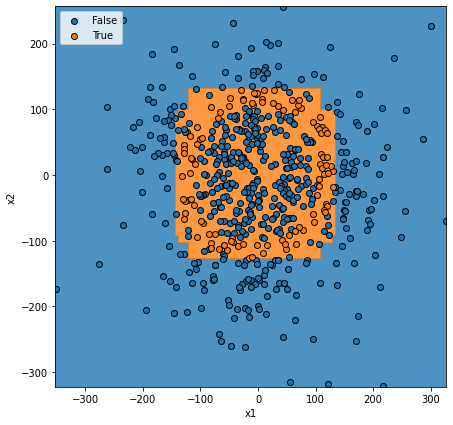

In [125]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

#### Level 3 (manual fix)

In [126]:
level = 3
rules, constraints, instance_indices_per_rule = zip(*explanations_l3)

In [127]:
print_rules(rules)
global_fidelities[(level, node.focus_class)] = node.root.evaluate_rules(*rules)

1. -127.2 < x2 <= -67.3 and -121.1 < x1 <= 104.4
2. 69.4 < x2 <= 132.4 and -105.5 < x1 <= 108.3
3. -127.3 < x2 <= -99.2 and -60.6 < x1 <= 44.0
4. 100.4 < x2 <= 132.5 and -53.1 < x1 <= 55.8
5. -103.1 < x2 <= -25.9 and -138.7 < x1 <= -47.1
6. 28.4 < x2 <= 95.3 and -130.9 < x1 <= -78.1
7. -89.4 < x2 <= -37.6 and 72.8 < x1 <= 117.9
8. 62.7 < x1 <= 122.7 and -89.3 < x2 <= 100.2
9. -143.2 < x1 <= -89.9 and -91.6 < x2 <= 81.3
10. 86.5 < x1 <= 134.2 and -82.3 < x2 <= 93.9
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       499
        True       0.42      1.00      0.59       101

    accuracy                           0.77       600
   macro avg       0.71      0.86      0.71       600
weighted avg       0.90      0.77      0.79       600



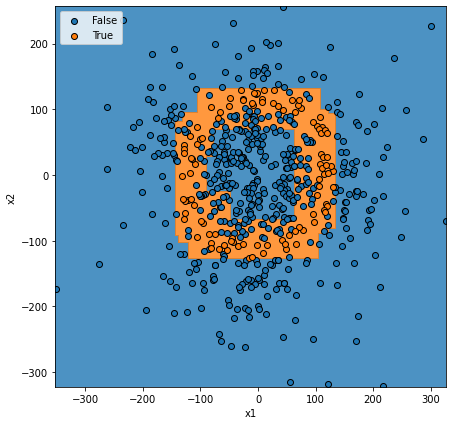

In [128]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

In [129]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.focus_class)] = statistics
statistics

,RMSE,BMR,BAR
x1,45.509101,0,0
x2,25.391541,0,0


In [130]:
res = get_complexity(constraints)
complexities[(level, node.focus_class)] = res
res

Rules          10
Constraints    40
dtype: int64

In [131]:
print_rules(rules)
node.root.evaluate_rules(*rules)

1. -127.2 < x2 <= -67.3 and -121.1 < x1 <= 104.4
2. 69.4 < x2 <= 132.4 and -105.5 < x1 <= 108.3
3. -127.3 < x2 <= -99.2 and -60.6 < x1 <= 44.0
4. 100.4 < x2 <= 132.5 and -53.1 < x1 <= 55.8
5. -103.1 < x2 <= -25.9 and -138.7 < x1 <= -47.1
6. 28.4 < x2 <= 95.3 and -130.9 < x1 <= -78.1
7. -89.4 < x2 <= -37.6 and 72.8 < x1 <= 117.9
8. 62.7 < x1 <= 122.7 and -89.3 < x2 <= 100.2
9. -143.2 < x1 <= -89.9 and -91.6 < x2 <= 81.3
10. 86.5 < x1 <= 134.2 and -82.3 < x2 <= 93.9
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       499
        True       0.42      1.00      0.59       101

    accuracy                           0.77       600
   macro avg       0.71      0.86      0.71       600
weighted avg       0.90      0.77      0.79       600



,Precision,Recall,F1 Score,Support
False,1.000000,0.717435,0.835473,499
True,0.417355,1.000000,0.588921,101


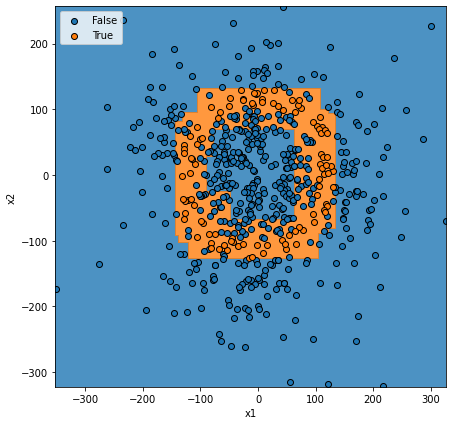

In [132]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

### Additional Plots

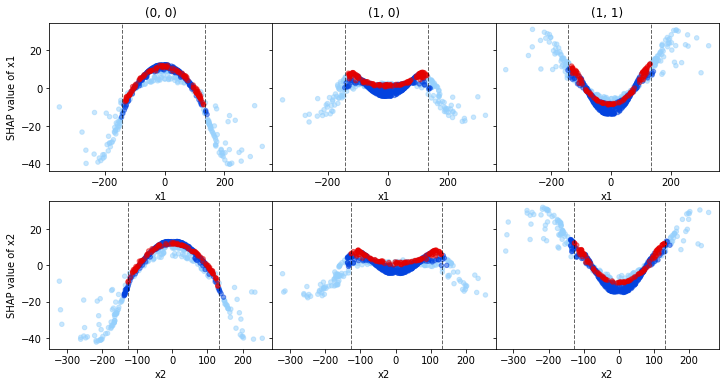

In [15]:
node = node.root.get('RL')
node.root.plot_feature_dependence(*feature_names, focus=node, alpha=0.5, figsize=(4, 3))
plt.savefig('gaussian-global-depplots-10.pdf')

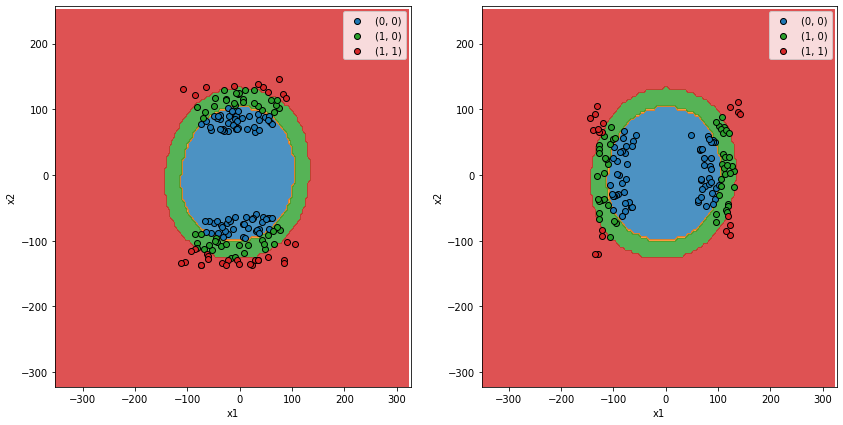

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
comparer.plot_decision_boundaries(node.root.get('RLL').data, xlim=xlim, ylim=ylim, mesh_step_size=5, fig=fig, ax=axs[0])
comparer.plot_decision_boundaries(node.root.get('RLRR').data, xlim=xlim, ylim=ylim, mesh_step_size=5, fig=fig, ax=axs[1])
plt.savefig('gaussian-scatter-clusters.pdf')

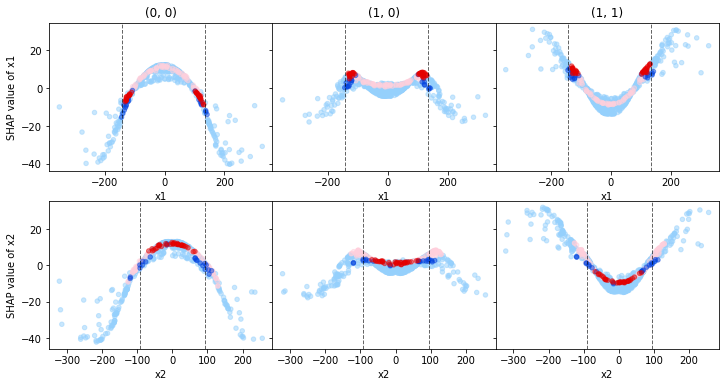

In [16]:
node = node.root.get('RLRRR')
node.root.plot_feature_dependence(*feature_names, focus=node, alpha=0.5, figsize=(4, 3))
plt.savefig('gaussian-local-depplots-10.pdf')

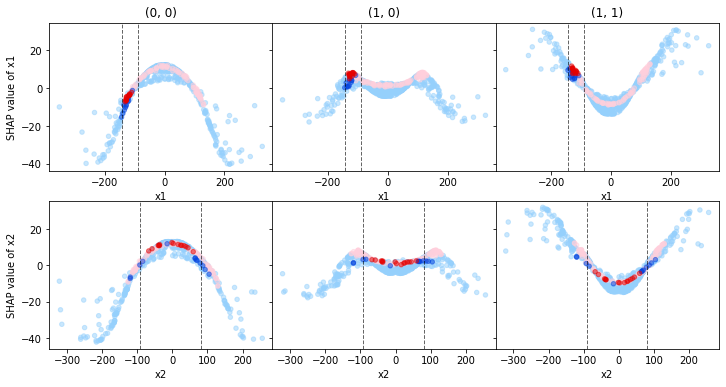

In [17]:
node = node.root.get('RLRRR')
node = node.filter(node.shap_values[:, 'x1'].data < 0)
node.root.plot_feature_dependence(*feature_names, focus=node, alpha=0.5, figsize=(4, 3))
plt.savefig('gaussian-local-depplots-10-fix.pdf')

# Summary

In [133]:
def map_index(index):
    class_, level_in = index[0], index[1]
    if level_in == 0:
        level = 'global'
    elif level_in == 2:
        level = 'local'
    elif level_in == 3:
        level = 'local*'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [134]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('level', 'class'))
global_fidelity = global_fidelity[global_fidelity.index.get_level_values(2).astype(int) == 1]
global_fidelity.index = global_fidelity.index.droplevel(2)
global_fidelity = global_fidelity.reorder_levels(['class', 'level']).sort_index()
global_fidelity

Precision  Recall  F1 Score  Support
class  level                                      
(1, 0) 0       0.256997     1.0  0.408907      101
       1       0.259640     1.0  0.412245      101
       2       0.259640     1.0  0.412245      101
       3       0.417355     1.0  0.588921      101

## Local Fidelity

In [135]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('level', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'level', 'feature']).sort_index()
local_fidelity

RMSE  BMR  BAR
class  level feature                      
(1, 0) 0     x1       135.194633    0    0
             x2       125.338367    0    0
       1     x1       129.009662    0    0
             x2       118.463040    0    0
       2     x1       126.356720    0    0
             x2       117.630441    0    0
       3     x1        45.509101    0    0
             x2        25.391541    0    0

## Complexity

In [136]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('level', 'class')).T
complexity = complexity.reorder_levels(['class', 'level']).sort_index()
complexity

Rules  Constraints
class  level                    
(1, 0) 0          1            4
       1          2            8
       2          4           16
       3         10           40

## Generation Time

approx. 2min 37s

In [137]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('level').notnull()]

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('level').notnull()]

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('level').notnull()]

with open('results.proposed.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)